In [1]:
import torch
import torch.nn as nn
import math
import joblib

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW, lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import joblib
import numpy as np
import random as rd
import soundfile as sf
import pytorch_lightning as pl


In [2]:
def flatten(xss):
    return [x for xs in xss for x in xs]

S = 1
dataset_type = 'maestro'

if dataset_type == 'bach':
    datas = joblib.load("/kaggle/input/holedbach/jsb1-li-train.pkl")
    X = datas['X']
    X = np.array(X)[:, None, 10:90, :]
if dataset_type == 'maestro':
    datas = joblib.load("/kaggle/input/maestrorolls1/Maestro_Rolls1_d2.pkl")
    X = flatten(datas)
    X = np.array(X)[:, None, :, :]
print(X.shape)

"""datas_test = joblib.load("/kaggle/input/musescoremidi2rolls1/MS2_div4_dataset.pkl")
X_test = datas_test['X']
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]) # to 1 channel
X_test = X_test[:, :, 10:90, :]"""

from torch.utils.data import DataLoader
X = dataloader = DataLoader(X, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [3]:
datas = joblib.load("/kaggle/input/msrolls1/MuseScoreMidis2_a.pkl")
datas_val = joblib.load("/kaggle/input/msrolls1/MuseScoreMidis2_a.pkl")

In [4]:
mytest = torch.tensor(datas_val[49])

In [5]:
S = 1

index = []
for song_idx, song in enumerate(datas):
    for frag_idx in range(len(song)):
        index.append((song_idx, frag_idx))

index_val = []
for song_idx, song in enumerate(datas_val):
    for frag_idx in range(len(song)):
        index_val.append((song_idx, frag_idx))

class FragmentDataset(Dataset):
    def __init__(self, data, index):
        self.data = data
        self.index = index 

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        song_idx, frag_idx = self.index[idx]
        fragment = self.data[song_idx][frag_idx] 
        fragment = fragment[np.newaxis, :, :] 
        return torch.tensor(fragment, dtype=torch.float32)

dataset = FragmentDataset(datas, index)
val_dataset = FragmentDataset(datas_val, index_val)


dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
print(len(dataloader), len(val_dataloader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

66 261
cuda


import gc; gc.collect()
del datas

# Model

In [37]:
class VectorQuantizer(nn.Module):
    """Vector Quantization layer for VQ-VAE (without EMA)"""

    def __init__(self, num_embed, embed_dim, beta):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embed_dim
        self._num_embeddings = num_embed

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1 / self._num_embeddings, 1 / self._num_embeddings)
        self._commitment_cost = beta
        
        # Track code usage for reinitialization
        self.register_buffer('_code_usage', torch.zeros(num_embed))
        self.register_buffer('_total_steps', torch.zeros(1))

    def forward(self, inputs):
        B, C, H_latent, W_latent = inputs.shape

        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape 

        flat_input = inputs.view(-1, self._embedding_dim) 

        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1) 

        # Update code usage tracking
        if self.training:
            self._code_usage += torch.sum(encodings, dim=0)
            self._total_steps += 1

        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices.view(B, H_latent, W_latent)

    def reset_unused_codes(self, usage_threshold=0.01):
        """Reset codes that are used less than the threshold"""
        if self._total_steps > 0:
            with torch.no_grad():
                usage_freq = self._code_usage / self._total_steps
                unused_mask = usage_freq < usage_threshold
                
                if unused_mask.any():
                    n_unused = unused_mask.sum().item()
                    # Reinitialize with small random values
                    self._embedding.weight.data[unused_mask] = torch.randn(
                        n_unused, self._embedding_dim, device=self._embedding.weight.device
                    ) * (1 / self._num_embeddings)
                    
                    # Reset usage counters for reinitialized codes
                    self._code_usage[unused_mask] = 0
                    
                    return n_unused
        return 0


class VectorQuantizerEMA(nn.Module):

    def __init__(self, num_embed, embed_dim, beta, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embed_dim
        self._num_embeddings = num_embed

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = beta

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embed))
        self._ema_w = nn.Parameter(torch.Tensor(num_embed, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        B, C, H_latent, W_latent = inputs.shape

        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        flat_input = inputs.view(-1, self._embedding_dim) 

        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                        (self._ema_cluster_size + self._epsilon)
                        / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w.data.copy_(self._ema_w * self._decay + (1 - self._decay) * dw) # Use .copy_() for in-place update

            self._embedding.weight.data.copy_(self._ema_w / self._ema_cluster_size.unsqueeze(1)) # Use .copy_()

        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices.view(B, H_latent, W_latent)

    def reset_unused_codes(self, usage_threshold=0.01):
        """Reset codes with low EMA cluster size"""
        with torch.no_grad():
            total_usage = self._ema_cluster_size.sum()
            if total_usage > 0:
                usage_freq = self._ema_cluster_size / total_usage
                unused_mask = usage_freq < usage_threshold
                
                if unused_mask.any():
                    n_unused = unused_mask.sum().item()
                    # Reinitialize embedding and EMA weights
                    self._embedding.weight.data[unused_mask] = torch.randn(
                        n_unused, self._embedding_dim, device=self._embedding.weight.device
                    ) * 0.01
                    self._ema_w.data[unused_mask] = torch.randn(
                        n_unused, self._embedding_dim, device=self._ema_w.device
                    ) * 0.01
                    
                    # Reset cluster sizes for reinitialized codes
                    self._ema_cluster_size[unused_mask] = 0
                    
                    return n_unused
        return 0


class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False),
            
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False),
            
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 1, bias=False), 
        )
    def forward(self, x):
        return x + self.block(x)


class ResidualStack(nn.Module):
    def __init__(self, dim, num_residual=2):
        super(ResidualStack, self).__init__()
        self.num_residual = num_residual
        self.layers = nn.ModuleList([ResBlock(dim) for _ in range(num_residual)])

    def forward(self, x):
        for i in range(self.num_residual):
            x = self.layers[i](x)
        return x


class PianorollVQVAELightning(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams) # Saves hyperparameters to self.hparams
        self.vqvae = VectorQuantizedVAE(
            inc=hparams['in_channels'],
            num_embed=hparams['num_embeddings'],
            embed_dim=hparams['embedding_dim'],
            num_residual=hparams['num_residual_layers'], # Map to num_residual
            beta=hparams['commitment_cost'],
            decay=hparams.get('decay', 0.99) # Use decay if provided, else default to 0.99
        )
    
    def forward(self, x):
        return self.vqvae(x)
    
    def _common_step(self, batch, batch_idx, step_type: str):
        x = batch.float()
        x[x > 0] = 1
        x[x < 1] = 0
    
        q_loss, x_recon, perplexity, indices = self(x)
    
        # Weighted BCEWithLogitsLoss for handling imbalance
        pos_weight = torch.tensor([10], device=x.device)
        recon_loss = F.binary_cross_entropy_with_logits(
            x_recon, x, reduction='mean', pos_weight=pos_weight
        )
    
        total_loss = recon_loss + self.hparams.beta * q_loss
        target_perplexity = self.hparams.num_embeddings * 0.9  
        perplexity_loss = F.l1_loss(perplexity, torch.tensor(target_perplexity, device=x.device))
        
        total_loss = recon_loss + self.hparams.beta * q_loss + 0.002 * perplexity_loss
    
        # Logging
        self.log(f'{step_type}/recon_loss', recon_loss, prog_bar=(step_type == 'train'))
        self.log(f'{step_type}/vq_loss', q_loss, prog_bar=(step_type == 'train'))
        self.log(f'{step_type}/total_loss', total_loss, prog_bar=(step_type == 'train'))
        self.log(f'{step_type}/perplexity', perplexity, prog_bar=(step_type == 'train'))
        
        # Reset unused codes periodically
        if step_type == 'train' and self.global_step > 0 and self.global_step % 200 == 0:
            n_reset = self._reset_unused_codes()
            if n_reset > 0:
                self.log('train/codes_reset', n_reset)
    
        return total_loss, x, x_recon
    
    def _reset_unused_codes(self):
        """Reset unused codes in the VQ layer"""
        if hasattr(self.vqvae, 'vq') and hasattr(self.vqvae.vq, 'reset_unused_codes'):
            return self.vqvae.vq.reset_unused_codes(usage_threshold=0.01)
        elif hasattr(self.vqvae, 'quantizer') and hasattr(self.vqvae.quantizer, 'reset_unused_codes'):
            return self.vqvae.quantizer.reset_unused_codes(usage_threshold=0.01)
        return 0
    
    def training_step(self, batch, batch_idx):
        loss, _, _ = self._common_step(batch, batch_idx, step_type='train')
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, x_orig, x_recon = self._common_step(batch, batch_idx, step_type='val')
        
        # Log reconstructions to wandb every N validation steps
        if batch_idx % 10 == 0 and hasattr(self.logger, 'experiment'):  # Log every 10th batch
            self._log_reconstructions_to_wandb(x_orig, x_recon, batch_idx)
        
        # Log codebook usage statistics
        if batch_idx == 0:
            self._log_codebook_stats()
        
        return loss
    
    def _log_codebook_stats(self):
        """Log codebook usage statistics"""
        try:
            if hasattr(self.vqvae, 'vq'):
                vq_layer = self.vqvae.vq
            elif hasattr(self.vqvae, 'quantizer'):
                vq_layer = self.vqvae.quantizer
            else:
                return
                
            if hasattr(vq_layer, '_code_usage') and hasattr(vq_layer, '_total_steps'):
                # For non-EMA version
                if vq_layer._total_steps > 0:
                    usage_freq = vq_layer._code_usage / vq_layer._total_steps
                    active_codes = (usage_freq > 0.01).sum().item()
                    self.log('val/active_codes', active_codes)
                    self.log('val/codebook_usage_ratio', active_codes / self.hparams.num_embeddings)
            elif hasattr(vq_layer, '_ema_cluster_size'):
                # For EMA version
                total_usage = vq_layer._ema_cluster_size.sum()
                if total_usage > 0:
                    usage_freq = vq_layer._ema_cluster_size / total_usage
                    active_codes = (usage_freq > 0.01).sum().item()
                    self.log('val/active_codes', active_codes)
                    self.log('val/codebook_usage_ratio', active_codes / self.hparams.num_embeddings)
        except Exception as e:
            pass  # Silently handle any errors in logging
    
    def test_step(self, batch, batch_idx):
        loss, _, _ = self._common_step(batch, batch_idx, step_type='test')
        return loss
    
    def _log_reconstructions_to_wandb(self, x_orig, x_recon, batch_idx, num_samples=4):
        """Log original and reconstructed pianorolls to wandb"""
        try:
            # Convert to numpy and apply sigmoid to reconstructions
            x_orig_np = x_orig.detach().cpu().numpy()
            x_recon_np = torch.sigmoid(x_recon).detach().cpu().numpy()
            
            # Select first num_samples from batch
            batch_size = min(num_samples, x_orig_np.shape[0])
            
            images_to_log = []
            
            for i in range(batch_size):
                # Create comparison figure
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                
                # Original pianoroll
                ax1.imshow(x_orig_np[i].squeeze(), aspect='auto', origin='lower', cmap='Blues')
                ax1.set_title('Original')
                ax1.set_xlabel('Time')
                ax1.set_ylabel('Pitch')
                
                # Reconstructed pianoroll
                ax2.imshow(x_recon_np[i].squeeze(), aspect='auto', origin='lower', cmap='Blues')
                ax2.set_title('Reconstructed')
                ax2.set_xlabel('Time')
                ax2.set_ylabel('Pitch')
                
                plt.tight_layout()
                
                # Convert to wandb image
                images_to_log.append(wandb.Image(fig, caption=f'Sample {i}'))
                plt.close(fig)
            
            # Log to wandb
            self.logger.experiment.log({
                f"val/reconstructions_batch_{batch_idx}": images_to_log,
                "epoch": self.current_epoch,
                "global_step": self.global_step
            })
            
        except Exception as e:
            print(f"Warning: Failed to log reconstructions to wandb: {e}")
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.learning_rate)
        if self.trainer is not None and self.trainer.datamodule is not None:
            total_training_steps = self.trainer.max_epochs * len(self.trainer.datamodule.train_dataloader())
        else:
            print("Warning: Dataloader info not available for LR scheduler T_max calculation. Using a fixed T_max.")
            total_training_steps = 1000 
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_training_steps, eta_min=1e-6)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val/total_loss', # Metric to monitor for scheduling
                'interval': 'step', # Apply scheduler every step for CosineAnnealingLR
                'frequency': 1
            }
        }
    
    def encode(self, x):
        return self.vqvae.get_codebooks_idx(x)
    
    def decode_indices(self, indices):
        return self.vqvae.decode_from_latent_indices(indices)

In [38]:
hparams = {
        'in_channels': 1,
        'hidden_dim': 128, 
        'embedding_dim': 256,
        'num_embeddings': 128,
        'num_residual_layers': 2,
        'commitment_cost': 0.1,
        'learning_rate': 2e-4,
        'beta': 0.25,
        'decay': 0.9,
        'batch_size': 32,
        'epochs': 1,
    }
model = PianorollVQVAELightning(hparams)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params:_}")

Number of parameters: 9_257_473


# Lighting Training

import gc; gc.collect()
torch.cuda.empty_cache()

In [15]:
!pip install wandb
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: prignano-2122585 (prignano-2122585-sapienza-universit-di-roma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [39]:
from pytorch_lightning.loggers import WandbLogger
import wandb
wandb.finish()
wandb_logger = WandbLogger(
    project="transformer-vqvae",
    name="VqMSRolls1_run2", 
    log_model=False             
)

epoch,▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████████
train/perplexity,▅▁▁▅▅▅▄▄▄▃▃▄▄▃▄▂▄▄▄▅▄▅▇▅▅▆▇▆▅▅▅▆▅▇▇▇█▆▇▅
train/recon_loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/vq_loss,▁▁▂▄▅▅▅▂▂▂▃▅▅▅▆▆▇▇▆▆▆▇▇▇▇▇▇███▇▇▆▇▇▅▆▆▆▅
trainer/global_step,▁▁▁▁▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
val/perplexity,▁▁▂▄▆▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
val/recon_loss,█▇▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▇▇▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val/vq_loss,▁▁▁▂▂▃▃▄▅▆▇▇▇▇▇▇▇▇███▇▇▇▇▆▆▆▆▆
epoch,2


In [42]:
dataloader = DataLoader(dataset, batch_size=48, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

trainer = pl.Trainer(
        max_epochs=3,
        accelerator='gpu',
        devices=1,         
        log_every_n_steps=1,
        val_check_interval=0.1,
        logger=wandb_logger
    )

trainer.fit(model, dataloader, val_dataloader)
torch.save(model, "VqMidi_MSROLLS_test128_9mln_ep2.pt")

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory ./transformer-vqvae/t95fbhyd/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

torch.save(model, "VqMidi_Maestro_test128_19mln_ch1.pt")

In [33]:
# EXPAND A PIANOROLL TO 128 PITCH (NEEDED for the synthesis function)
def to_128(x):
    mapped = torch.zeros((128, x.shape[1]))
    mapped[20:100, :] = x
    return mapped

# FUNCTIONS
!pip install pretty_midi
import pretty_midi
S = 1
def S_to_pitch(pitch):
    return pitch + (S-1) if pitch % 2 == 1 else pitch

def multi_hot_to_midi(piano_roll: np.ndarray, time_per_step: float = 0.06/3.3,
                      velocity: int = 100) -> pretty_midi.PrettyMIDI:
    print(piano_roll.shape)
    T, n_pitches = piano_roll.shape
    if n_pitches != 128:
        raise ValueError("The input piano roll must have 128 columns (for MIDI notes 0-127).")

    midi_obj = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    active_notes = {}

    for t in range(T):
        current_time = t * time_per_step
        current_frame = piano_roll[t]  # shape: (128,)

        for pitch in range(128):
            is_active = current_frame[pitch] > 0
            prev_active = piano_roll[t - 1][pitch] > 0 if t > 0 else False

            if is_active and not prev_active:
                active_notes[pitch] = current_time
            elif not is_active and prev_active:
                start_time = active_notes.pop(pitch, current_time)
                note = pretty_midi.Note(velocity=velocity, pitch=S_to_pitch(pitch)+12, start=start_time, end=current_time)
                instrument.notes.append(note)

    final_time = T * time_per_step
    for pitch, start_time in active_notes.items():
        note = pretty_midi.Note(velocity=velocity, pitch=S_to_pitch(pitch)+12, start=start_time, end=final_time)
        instrument.notes.append(note)

    midi_obj.instruments.append(instrument)
    return midi_obj

def midi_to_audio(midi_path, fs=44100, tempo=100, autoplay=False):
    pm = midi_path                                                

    wav = pm.synthesize(fs)                                          
    wav = wav / np.max(np.abs(wav))                                  
    return Audio(wav, rate=fs, autoplay=autoplay)   

import pretty_midi
import matplotlib.pyplot as plt
import numpy as np

def plot_midi_pianoroll(midi_path, fs=100):
    pm = midi_path
    
    piano_roll = pm.get_piano_roll(fs=fs)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='gray_r', 
               extent=[0, piano_roll.shape[1] / fs, 0, 128])
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Pitch')
    plt.title('Piano Roll')
    plt.colorbar(label='Velocity')
    plt.tight_layout()
    plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 13.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=bc1488fad39fe07b6550e14a60fef4ca1ca457d38d31a37de61edcaa6019116c
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


  8%|▊         | 21/261 [00:01<00:12, 18.67it/s]


torch.Size([8, 10, 128])


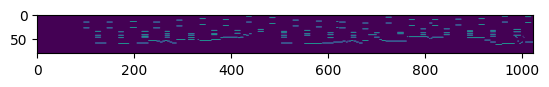

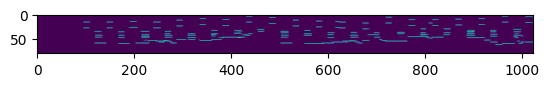

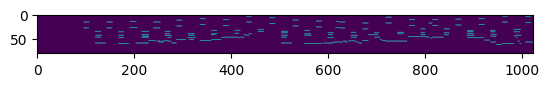

torch.Size([128, 1024])
(1024, 128)


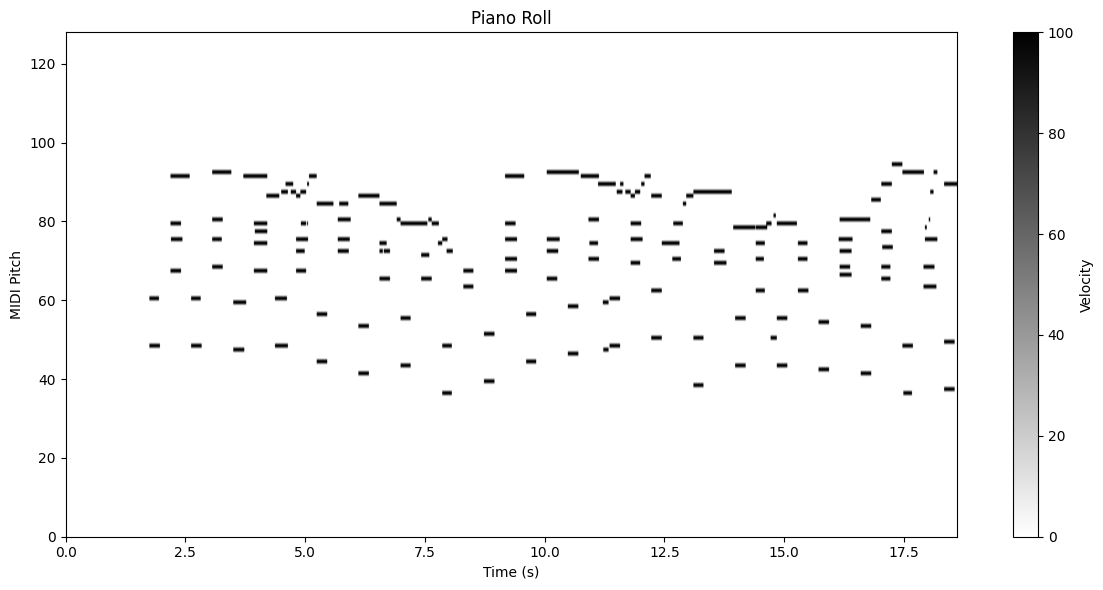

In [43]:
model.eval()
from tqdm import tqdm

for i, sample_input in enumerate(tqdm(val_dataloader)):
    sample_input[sample_input > 0] = 1
    sample_input[sample_input < 1] = 0

    sample_input = sample_input.to(model.device)
    if i == 21:
        break
# print(sample_input.dtype, mytest.dtype)     
sample_input =  mytest.unsqueeze(1).float()
sample_input[sample_input > 0] = 1
sample_input[sample_input < 1] = 0
with torch.no_grad():
    _, reconstructed_output, _, indicies = model(sample_input)

print(indicies.shape)
reconstructed_output = torch.sigmoid(reconstructed_output)
plt.imshow(sample_input[0, 0].cpu().numpy())
plt.show()
plt.imshow(reconstructed_output[0, 0].cpu().numpy())
plt.show()
tresh = 0.9
reconstructed_output[reconstructed_output > tresh] = 1
reconstructed_output[reconstructed_output <= tresh] = 0
plt.imshow(reconstructed_output[0, 0].cpu().numpy())
plt.show()

tolisten = reconstructed_output
tolisten = tolisten.squeeze(1)
_sample = to_128(tolisten[0].cpu())
print(_sample.shape)
midi = multi_hot_to_midi(_sample.cpu().numpy().T)
plot_midi_pianoroll(midi)
from IPython.display import Audio
midi.write('bachfromergen.mid')
midi_to_audio(midi)

In [ ]:
tolisten = sample_input
tolisten = tolisten.squeeze(1)
_sample = to_128(tolisten[0].cpu())
print(_sample.shape)
midi = multi_hot_to_midi(_sample.cpu().numpy().T)
plot_midi_pianoroll(midi)
from IPython.display import Audio
midi.write('bachfromergen.mid')
midi_to_audio(midi)

# Sampling

In [ ]:
with torch.no_grad():
    reconstructed_output = model.vqvae.decode_from_latent_indices(torch.randint(0, 128, size=(1, 10, 64), device=model.device)*0 + 43)

reconstructed_output[reconstructed_output > tresh] = 1
reconstructed_output[reconstructed_output <= tresh] = 0
plt.imshow(reconstructed_output[0, 0].cpu().numpy())
plt.show()

In [ ]:
tolisten = reconstructed_output
tolisten = tolisten.squeeze(1)
_sample = to_128(tolisten[0].cpu())
print(_sample.shape)
midi = multi_hot_to_midi(_sample.cpu().numpy().T)
plot_midi_pianoroll(midi)
from IPython.display import Audio
midi.write('bachfromergen.mid')
midi_to_audio(midi)